### Summary 

### Data Libraries 

In [2]:
import numpy as np 
import pandas as pd
import os 
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

### Data Visualization

In [3]:
!ls

'Cancer Detection.ipynb'   data   models


In [4]:
PATH = 'data/'
df = pd.read_csv(f'data/train_labels.csv', engine='python')

In [5]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
df.shape

(220025, 2)

In [7]:
train_path = 'data/train/'
test_path = 'data/test/'

In [8]:
df['label'].value_counts(normalize=True)

0    0.594969
1    0.405031
Name: label, dtype: float64

In [9]:
shuffled_data = shuffle(df)

In [10]:
idx = shuffled_data[shuffled_data['label'] == 0]['id'][:1]

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [36]:
path_test = os.path.join(test_path, idx)

In [37]:
path_test

'data/test/fb540d97f4d200f2534a0a099bcb9c40014e1455'

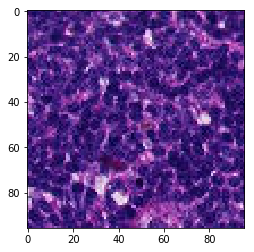

In [38]:
img = mpimg.imread(path_test +'.tif')

plt.imshow(img)

Let's look at some images

Text(0, 0.5, 'Postive Samples')

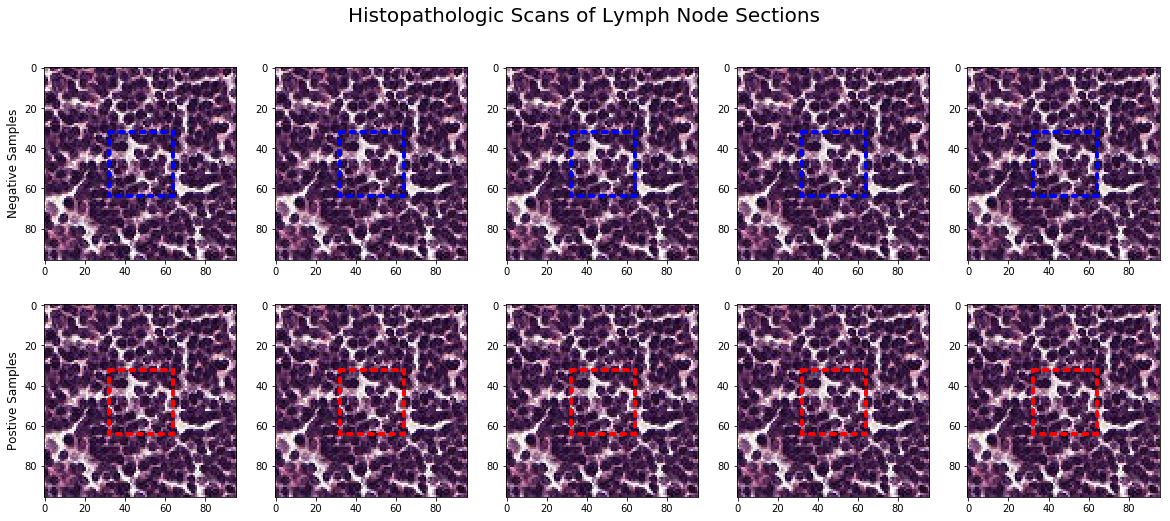

In [16]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic Scans of Lymph Node Sections', fontsize=20)

#Let's get some negative examples to look at
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]): 
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(mpimg.imread(path_test +'.tif'))
    # Create The 32x32 box image 
    box = patches.Rectangle((32,32), 32,32, linewidth=4, edgecolor='b', facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative Samples', size='large')

#Now time to get some postive samples
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1, i].imshow(mpimg.imread(path_test +'.tif'))
    #Again create the 32x32 image bounding box
    box = patches.Rectangle((32,32), 32,32, linewidth=4, edgecolor='r', facecolor='none', linestyle=':', capstyle='round')
    ax[1, i].add_patch(box)
ax[1,0].set_ylabel('Postive Samples', size='large')

### Augumentation In OpenCV

Mannually using data manipulation with OpenCV more to come on this when the Fastai library is implemented in this notebook for now we are going to use what we know about doing this with OpenCV

There is a lot we can do, but here are some things that I am going to do and if I have time will come back and do this as well. 

**Augmentations Used**

 * Random Rotation
 * Random Crop 
 * Random flip (Horizonal & Vertical Flips) 
 * Random Lighting
 
**Augmentations Still To Implement**

 * Random Zoom (Fastai)
 * Gaussian Blur 
 * Inverse (Fastai) 
 * Mirroring (Fastai)

In [17]:
import random 

#This is the orginal size of all the images
ORIGINAL_SIZE = 96 

#Augmentation variables (**USED**)
CROP_SIZE = 90        # Final size after crop
RANDOM_ROTATION = 3   # range (0-180), 180 allows all roations variiation, 0 = no change
RANDOM_SHIFT = 2      # center crop shift in x and y axes, 0 = no change. This can't be more than the (Orginial - crop)//2
RANDOM_BRIGHTNESS = 7 # Range (0-100), 0=nochange
RANDOM_CONTRAST = 5   # Range (0-100), 0=nochange
RANDOM_90_DEG_TURN = 1# 0 or 1 = random turn to left or right

In [18]:
def readCroppedImage(path, augmentations= True): 
    '''
    Augmentation paramters are included for counting statistics from images
    where one doesn't want to have augmentations.
    '''
    #read images with OpenCV
#     print(path)
    bgr_img = cv2.imread(path)
    #Flip to rgb for viz
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations): 
        return rgb_img /225 
    
    #random rotation 
    rotation = random.randint(-RANDOM_ROTATION, RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1): 
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48), rotation,1) # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    #crop to center and normalize to 0-1 range 
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    #normalize images
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    #random flip 
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor): 
        rgb_img = rgb_img[:,::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1,:]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    #clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

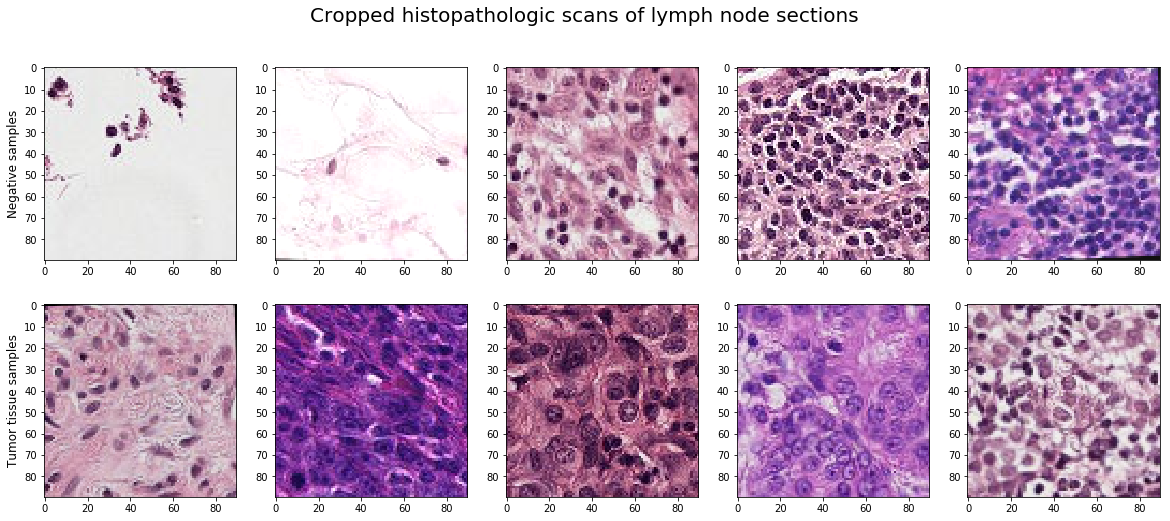

In [19]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif'))
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

Checking the result of this 

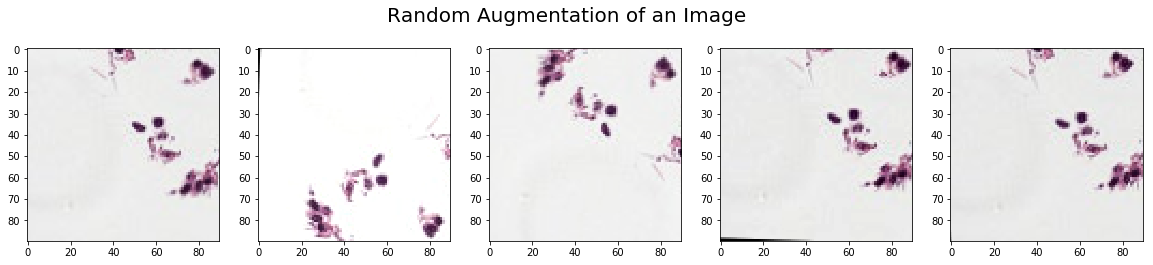

In [20]:
fig, ax = plt.subplots(1,5, figsize=(20,4))
fig.suptitle('Random Augmentation of an Image', fontsize=20)

#For negatives 
for i, idx in enumerate(shuffled_data[shuffled_data['label']==0]['id'][:1]):
    for j in range(5): 
        path = os.path.join(train_path, idx)
        ax[j].imshow(readCroppedImage(path + '.tif'))

Normalizing images is extremely important and a lot of time a great baseline is using the imagenet_stats, but for now for the purpose of this specific data set is to see how to get the statistics of our data set

 **Purpose**
 
 * Checking if thre are images that have a very low maximum pixel intensity
     - Low max == almost totally black and high == almost white 
 * Why This Happens? 
     - Anything from the camera, bad exposure or the cropped area even could be blank. 

In [21]:
dark_th = 10/255    # Does a pixel reaches this threshold (Image is considered too dark)
bright_th = 245/255 # If no pixel is under this threshold, (Image is considered to bright)

too_dark_idx = []
too_bright_idx = []

#Three lanes
x_tot = np.zeros(3)
x2_tot = np.zeros(3)
counted_ones = 0 

for i, idx in tqdm_notebook(enumerate(shuffled_data['id']), 'Function Computing Image Statistics'):
    path = os.path.join(train_path, idx)
    imagearray = readCroppedImage(path + '.tif', augmentations=False).reshape(-1,3)
    #Is it Dark? 
    if(imagearray.max() < dark_th): 
        too_dark_idx.append(idx)
        continue
    #Is it too bright?
    if(imagearray.min() > bright_th):
        too_bright_idx.append(idx)
        continue #will exclude this image in calculation
    x_tot += imagearray.mean(axis=0)
    x2_tot +=(imagearray**2).mean(axis=0)
    counted_ones += 1
    
channel_avr = x_tot/counted_ones
channel_std = np.sqrt(x2_tot/counted_ones - channel_avr**2)
channel_avr, channel_std

(array([0.79583625, 0.61863765, 0.78903647]),
 array([0.27073981, 0.31955782, 0.24504378]))

In [22]:
print('In this current data set there are {0} extremely dark images'.format(len(too_dark_idx)))
print('There are also {0} extremely bright images'.format(len(too_bright_idx)))
print(too_dark_idx)
print(too_bright_idx)

In this current data set there are 1 extremely dark images
There are also 223 extremely bright images
['9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
['b7e2bc77f2cf29ab75243fb49834ccdafbce5a7c', '95df11d4fcc9bb338d9518ccd015a429fd5945c2', '825c2a20425dd84cf6da154e9f09f7fe4aa85d6a', '405900429a24a89fbb876f30b23779ed7bc2b85c', '82e537b916ca30be0c4de6e6fa6460ffdcea2ec4', '24a45c21c3180e56df13033009291cd67596f1ff', 'fc3b797211cb8676a9c79c9d5df63e9cd902a16c', 'cf1bdd57b56ec9fd5feb1f50525c342587684502', '757a57503a7bf0ade468456b3698f9443ee86af3', 'c826e92fb4b2fd1732b32e7cc6ffc27ab139a655', '7684f646ab56865be79eb2fa7b8e6d3b70235c65', 'ad13e9bef43edf29ef1afcab0b9464963775f977', '95aefdfd255d23b1ffdd31195b38a4f4f55a8a0c', '53bf70f96738fae140d85986ece0ea714efc0c2c', '7f88140c49153bc3a7fb9329c64e1b50831c1e73', 'cf03a9351dba6b92836f33d6ac1793c77b6d09e0', '25a274c053ae773c0b5b21e07801633e3486246e', 'fc9991c140b70881bb3acbced360bf819c534479', '6e6e347958454820bcbdec7298c87bf3bc63f5fa', 'eca89e013f823c9

Let's look at these extreme photos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


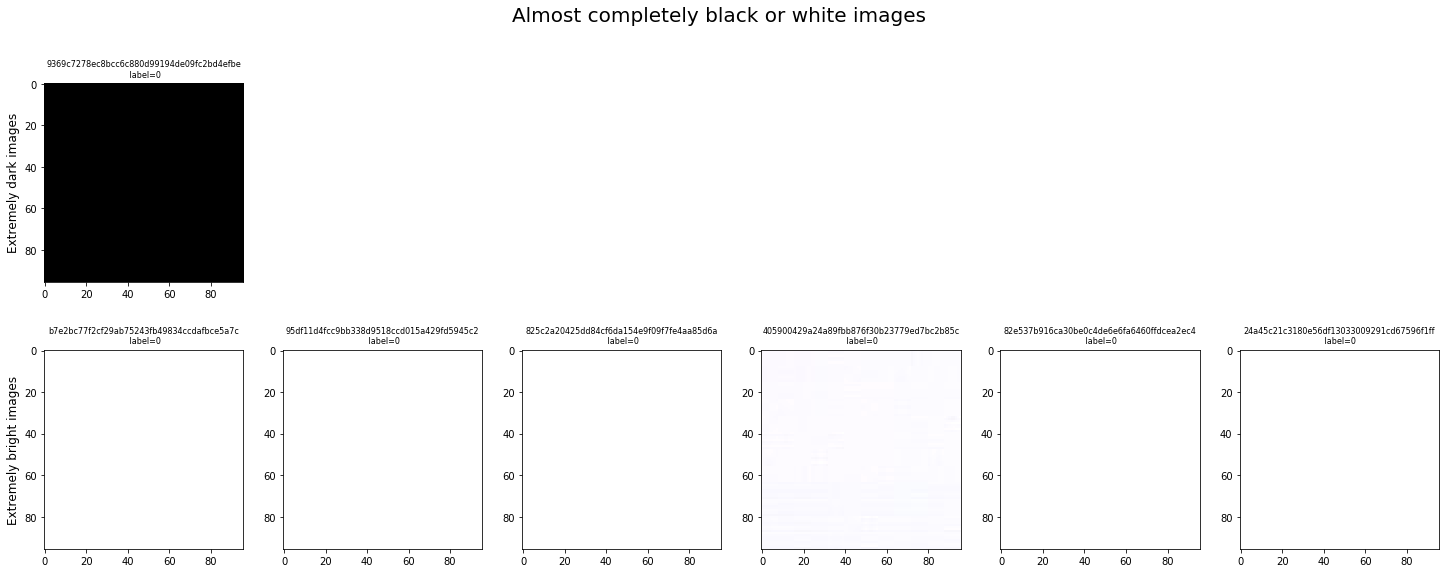

In [23]:
fig, ax = plt.subplots(2,6, figsize=(25,9))
fig.suptitle('Almost completely black or white images',fontsize=20)
# Too dark
i = 0
for idx in np.asarray(too_dark_idx)[:min(6, len(too_dark_idx))]:
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif', augmentations = False))
    ax[0,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8)
    i += 1
ax[0,0].set_ylabel('Extremely dark images', size='large')
for j in range(min(6, len(too_dark_idx)), 6):
    ax[0,j].axis('off') # hide axes if there are less than 6
# Too bright
i = 0
for idx in np.asarray(too_bright_idx)[:min(6, len(too_bright_idx))]:
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif', augmentations = False))
    ax[1,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8)
    i += 1
ax[1,0].set_ylabel('Extremely bright images', size='large')
for j in range(min(6, len(too_bright_idx)), 6):
    ax[1,j].axis('off') # hide axes if there are less than 6

This is part of the data science releam. Even though this is still going to be a MVP model for the project we are looking to remove this data as there is nothing to be learned from images like this. 

**WHY ARE THEY HERE?**

This can only be asked of the data collectors and this is something we would like to know. From the images looked at we can see that they are all as negative appearance of a tumor. We are going to remove these images from the data set and move forward and get ride ~250 images

### Fastai Baseline Model

In [24]:
#Lets take care of removing the data that we found as foul play
df_train = df.set_index('id');df_train.head()

,label
id,
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0


In [25]:
#Removing the too bright and too dark
len(df_train)

220025

In [26]:
df_train = df_train.drop(labels=too_bright_idx, axis=0)
df_train = df_train.drop(labels=too_dark_idx, axis=0)
len(df_train)

219801

In [27]:
#splitting the data here with a 90/10 stratified split of the independent vairable 
train_names = df_train.index.values
train_labels = np.asarray(df_train['label'].values)

In [28]:
train_names.shape, train_labels.shape

((219801,), (219801,))

In [29]:
#Fastai will take care of most of this, but we want the val/train idxs
train_df, valid_df, train_idx, valid_idx = train_test_split(train_names, range(len(train_names)), test_size=0.1,
                                                            stratify=train_labels, random_state=123)

In [30]:
train_df.shape, valid_df.shape, len(train_idx), len(valid_idx)

((197820,), (21981,), 197820, 21981)

**Model Architeture For This Problem Set?**

The choice here is to use a pre-trained convnet model and transfer the learning to adjust the weights to our data. 

In [31]:
from fastai import * 
from fastai.vision import * 
from torchvision import * 

In [32]:
arch = models.densenet169(); arch

/home/jdemlow/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

[densenetpaper](https://arxiv.org/abs/1608.06993) & [pytorch_pretrained_options](https://pytorch.org/docs/stable/torchvision/models.html)

In [139]:
# arch = densenet169   #Changing this will be key for future experiements 
BATCH_SIZE = 128 #might need to adjust to 64 depending on memory
sz = CROP_SIZE 
MODEL_PATH = str(arch).split()[0].replace('(','') 

In [33]:
# train_dict = {'name': train_path + train_names, 'label': train_labels}
# df = pd.DataFrame(data = train_dict);df.head()

In [79]:
train_dict = {'name': train_path + train_names, 'label': train_labels}
df = pd.DataFrame(data = train_dict);df.head()

,name,label
0,data/train/f38a6374c348f90b587e046aac6079959ad...,0
1,data/train/c18f2d887b7ae4f6742ee445113fa1aef38...,1
2,data/train/755db6279dae599ebb4d39a9123cce43996...,0
3,data/train/bc3f0c64fb968ff4a8bd33af6971ecae77c...,0
4,data/train/068aba587a4950175d04c680d38943fd488...,0


In [80]:
# test_names = []
# for f in os.listdir(test_path):
#     test_names.append(test_path + f)
# df_test = pd.DataFrame(np.asarray(test_names), columns=['name']); df_test.head()
test_names = []
for f in os.listdir(test_path):
    test_names.append(test_path + f)
df_test = pd.DataFrame(np.asarray(test_names), columns=['name']);df_test.head()
# df_test['name'] = df_test['name'].str.replace('.tif', '');df_test.head()

,name
0,data/test/fb540d97f4d200f2534a0a099bcb9c40014e...
1,data/test/5f53f9f84ee2c9e8a9f769129a54a188dd54...
2,data/test/20ccb7f5213a1921c78b184c84d5904253a2...
3,data/test/ac7f9cd9ddfbd13c6f28c58a0cc0c6f5b67e...
4,data/test/aed8520cb29c5a493a05d51b3d55e3b3aa93...


In [36]:
z = 'data/test/fb540d97f4d200f2534a0a099bcb9c40014e'

In [37]:
z.replace('/./','').replace('//','/')

'data/test/fb540d97f4d200f2534a0a099bcb9c40014e'

We load the images to an ImageDataBunch for the training. This fastai's data object is easily customized for loading images using our own ``readCroppedImage`` function. We just need to subclass ImageList. [Data API docs](https://docs.fast.ai/data_block.html)

In [103]:
# Subclass ImageList to use our own image opening function
class MyImageItemList(ImageItemList): #NOTE UPDATED FASTAI is now ImageList like ther rest of the lib Text and Tabular
     def open(self, fn:PathOrStr)->Image:
#         print(fn)
#         print(fn.replace('//./','').replace('//','/'))
        img = readCroppedImage(fn.replace('//./','').replace('//','/'))
#         print(fn.replace('./',''))
#         img = readCroppedImage(fn.replace('./',''))
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        return vision.Image(px=pil2tensor(img, np.float32))

In [104]:
df_test.head()

,name
0,data/test/fb540d97f4d200f2534a0a099bcb9c40014e...
1,data/test/5f53f9f84ee2c9e8a9f769129a54a188dd54...
2,data/test/20ccb7f5213a1921c78b184c84d5904253a2...
3,data/test/ac7f9cd9ddfbd13c6f28c58a0cc0c6f5b67e...
4,data/test/aed8520cb29c5a493a05d51b3d55e3b3aa93...


```python
tensor([0.79583625, 0.61863765, 0.78903647]),
tensor([0.27073981, 0.31955782, 0.24504378])
```

In [105]:
train_path = '/data/train/'
test_path = '/data/test/'

In [106]:
#The Magic of Fastai Building Blocks API 
data = (
    MyImageItemList.from_df(path='/', df=df, suffix='.tif')#Where is the data
    .split_by_idx(valid_idx)#How to split the data
    .label_from_df(cols='label')#Getting the labels for the data from the df here the csv
    .add_test(MyImageItemList.from_df(path='/', df=df_test)) #suffix='.tif')) #Use the df_test as test 
#     .add_test(ImageItemList.from_folder(path='data/test/')) #Use the df_test as test 
    .transform(tfms=[[],[]], size=sz)#This will be where we will improve this MVP the most
    #Why is it empty? -> we set two empty list to tfms for the training and the validation 
    .databunch(bs=BATCH_SIZE) #batchsize
    #.normalize(imagenet_stats) 
    #Normalize with the training set stats the means, and stds of the three channels calculated above
    .normalize([tensor([0.79583625, 0.61863765, 0.78903647]),tensor([0.27073981, 0.31955782, 0.24504378])])
)

In [107]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (197820 items)
[Category 1, Category 0, Category 0, Category 0, Category 1]...
Path: /
x: MyImageItemList (197820 items)
[Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90)]...
Path: /;

Valid: LabelList
y: CategoryList (21981 items)
[Category 1, Category 0, Category 0, Category 1, Category 1]...
Path: /
x: MyImageItemList (21981 items)
[Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90)]...
Path: /;

Test: LabelList
y: EmptyLabelList (57458 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: MyImageItemList (57458 items)
[Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90)]...
Path: /

In [40]:
# img = mpimg.imread('data/train/dac4b23e3ce0499a843cc4737f8158a8338721f4.tif')
# plt.imshow(img)

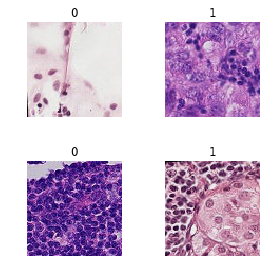

In [41]:
data.show_batch(rows=2, figsize=(4,4))

### Create a Learner in Fastai

How to create a convnet learner object and set the arch that we are wanting to use and give it the data bunch that is going to be used [Fastai Docs For create_cnn](https://docs.fast.ai/vision.learner.html#create_cnn)

In [108]:
# Next, we create a convnet learner object
# ps = dropout percentage (0-1) in the final layer
def getLearner():
    return create_cnn(data, models.densenet169, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

learner = getLearner()
# learner.clip_grad()
#Usual way in fastai 
# learn = create_cnn(data, models.densenet169, pretrained=True, metrics=accuracy, ps=0.5)

/home/jdemlow/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [109]:
#Always look at make sure what we are wanting is the case everything her looks in order 
learner.data.test_ds.path

PosixPath('/')

In [110]:
learner.data.test_ds.items

array(['//./data/test/fb540d97f4d200f2534a0a099bcb9c40014e1455.tif',
       '//./data/test/5f53f9f84ee2c9e8a9f769129a54a188dd542e26.tif',
       '//./data/test/20ccb7f5213a1921c78b184c84d5904253a2d540.tif',
       '//./data/test/ac7f9cd9ddfbd13c6f28c58a0cc0c6f5b67e84c0.tif', ...,
       '//./data/test/58ba2df04686bf614fee324201331ecc98d46bcf.tif',
       '//./data/test/9c08e36badca1b23733c6283f4784aa20c3fa9e8.tif',
       '//./data/test/64ea159c6cb227da8404cdc9ed63bb6ca9aa0a4e.tif',
       '//./data/test/f54f13d591313ea7e484226257a4173e27f5852f.tif'], dtype='<U59')

### Hyper Parameters

1 Cycle Policy 

**Leslie Smith** is who came up with this policy. This brings a more disciplined approach for selecting hyperparamters such as learning rate and weight decay. 

*Alot of times this will save me a lot of time from training with suboptimal hyperparameters.** Of course, the fastai library has this implemented. 

A clear explanation and probably the best one I know of is here [Explanation SG](https://sgugger.github.io/the-1cycle-policy.html)

To find the **optimal** ``Learning Rate`` and ``Weight Decay`` values. The optimal LR is just before the base of the loss and before the start of divergence. **WHY?** It's important that the loss is still descending where the learning rate is choosen. There isn't a perfect science yet, but I am sure this will be done for us soon. 

As for ``Weight Decay``, which is essentally the L2 penatly of the optimizer, in the 1 cycle policy to select the largest one that will still let us train at a high learning rate.

**Method** 

A small grid search will be used

In [52]:
# Use Lr_find with different weight decays and record all the losses 
# Iters is by default == 100
# This could be to low and might have to much variance so you can play with it
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


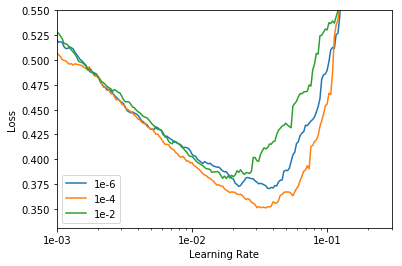

In [53]:
# Plotting The Above WD
_, ax = plt.subplots(1,1)
min_y = 0.5
max_y = 0.55

for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')

#ax range may need some tuning wiht different archs
ax.set_xlim((1e-3, 3e-1))
ax.set_ylim((min_y - 0.02, max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

Smaller datasets and architectures seem to require larger values for weight decay while larger datasets and deeper architectures seem to require smaller values. ``Leslie Smith``

### Training

In [62]:
name = f'densenet169-tuned-{CROP_SIZE}'

In [45]:
name

'densenet169-tuned-90'

In [46]:
learner.load(name)

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (197820 items)
[Category 1, Category 0, Category 0, Category 0, Category 1]...
Path: data/train
x: MyImageItemList (197820 items)
[Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90)]...
Path: data/train;

Valid: LabelList
y: CategoryList (21981 items)
[Category 1, Category 0, Category 0, Category 1, Category 1]...
Path: data/train
x: MyImageItemList (21981 items)
[Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90)]...
Path: data/train;

Test: LabelList
y: EmptyLabelList (57459 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: MyImageItemList (57459 items)
[Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90)]...
Path: data/train, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3

In [48]:
lr = 2e-2
wd = 1e-4

epoch,train_loss,valid_loss,accuracy
1,0.241994,0.338215,0.876894
2,0.189045,0.188632,0.927346
3,0.155701,0.149382,0.946044
4,0.146087,0.138727,0.948592


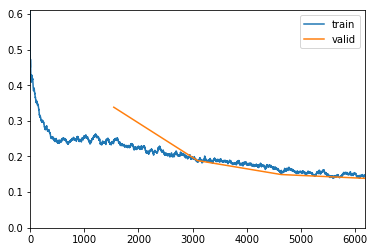

In [56]:
learner.fit_one_cycle(cyc_len=4, max_lr=lr, wd=wd)

epoch,train_loss,valid_loss,accuracy
1,0.188397,3.475084,0.928484
2,0.157757,0.148053,0.946181
3,0.139083,0.131216,0.952004


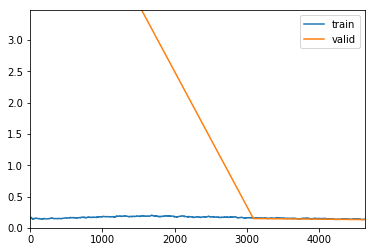

In [49]:
#We didn't overfit yet so let's continue to move forward with the same hyperparamters
learner.fit_one_cycle(cyc_len=3, max_lr=lr, wd=wd)

As you can see we can go even farther, but I want to save my results for now so that I can make sure this model doesn't get lost in the experiments. 

In [52]:
#save the model so we can load it later
learner.save(name)

In [63]:
#checking results if you want to see the call back
# learner.recorder.plot_losses()

In [50]:
interp = ClassificationInterpretation.from_learner(learner)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

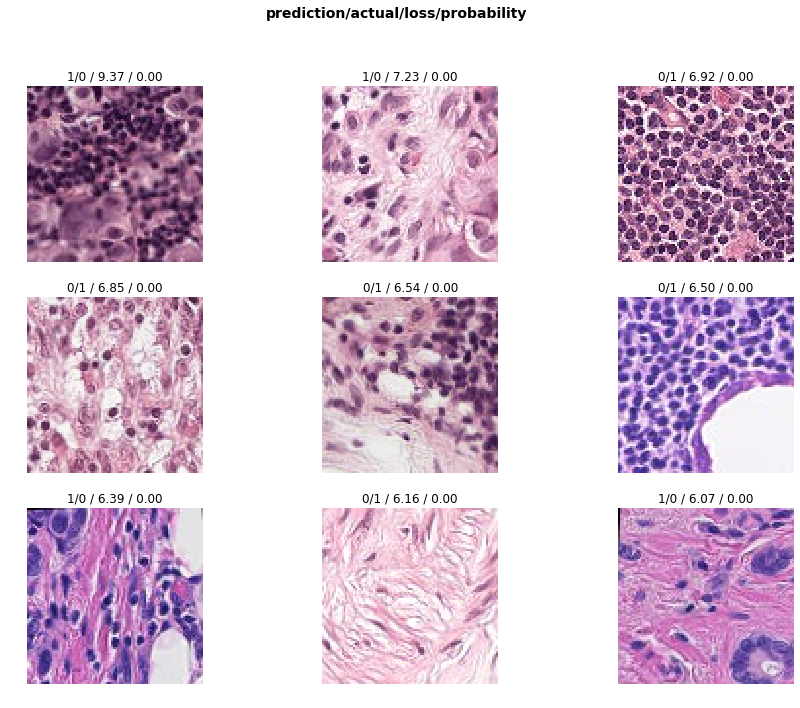

In [70]:
#The title of each image shows: prediction, actual, loss, probability of actual class. 
interp.plot_top_losses(9, figsize=(15,11))

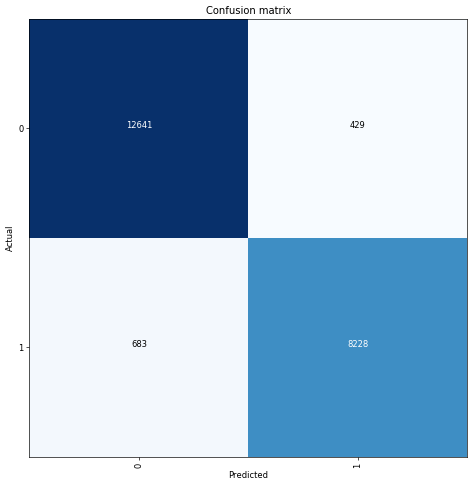

In [73]:
#confusion matrix
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

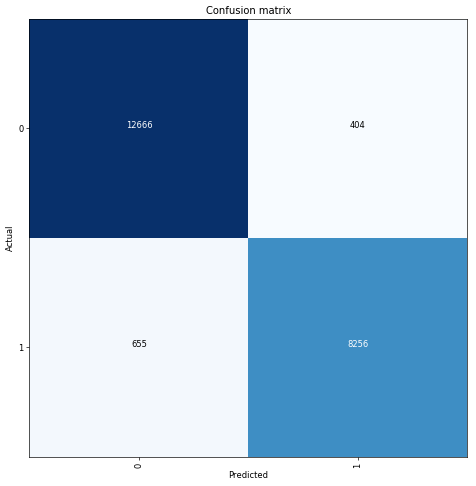

In [51]:
#confusion matrix 7 epochs in
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

**Confusion matrix** can help us understand the ratio of false negatives and positives and it's a fast way looking at our model's performance. This is a simple table that shows the counts in a way of actual label vs. predicted label. Here we can see that the model has learned to distinguish tumor and negative sample and it's already performing well. However, we will continue training further to improve from here.

**NOTE**

I didn't want to continue down this path as I am looking to get an MVP model so I will move on to unfreezing the arch allowing it to learn the more specifics. 

In [63]:
#load saved model 
learner.load(name)

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (197820 items)
[Category 1, Category 0, Category 0, Category 0, Category 1]...
Path: data/train
x: MyImageItemList (197820 items)
[Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90)]...
Path: data/train;

Valid: LabelList
y: CategoryList (21981 items)
[Category 1, Category 0, Category 0, Category 1, Category 1]...
Path: data/train
x: MyImageItemList (21981 items)
[Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90)]...
Path: data/train;

Test: LabelList
y: EmptyLabelList (57459 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: MyImageItemList (57459 items)
[Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90)]...
Path: data/train, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3

In [112]:
name = f'densenet169-tuned-unfrozen-{CROP_SIZE}'

In [65]:
learner.unfreeze()
learner.lr_find(wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


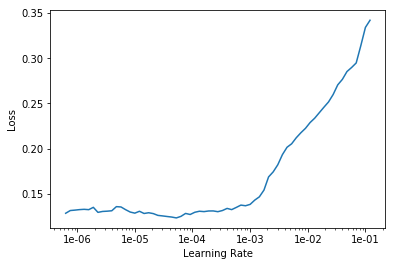

In [66]:
#plot the learning rate
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy
1,0.138262,0.129824,0.951595
2,0.145904,0.128884,0.953551
3,0.125632,0.125634,0.954597
4,0.126135,0.121265,0.957099
5,0.117964,0.113601,0.958828
6,0.111363,0.111090,0.960147
7,0.107206,0.104299,0.963514
8,0.104194,0.100810,0.963923
9,0.096848,0.101835,0.965015
10,0.099607,0.101327,0.963696


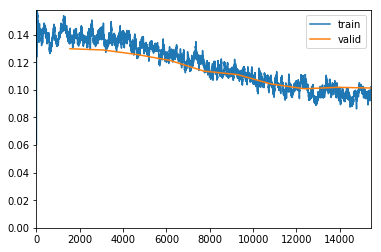

In [67]:
max_lr = 4e-5
# lrs = [max_lr/100, max_lr/10, max_lr]
learner.fit_one_cycle(cyc_len=10, max_lr=slice(4e-5,4e-4))

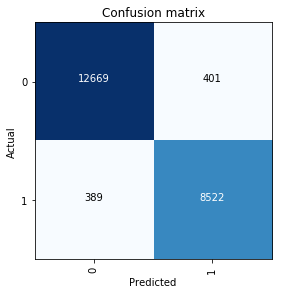

In [68]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [74]:
learner.save(name)

In [111]:
name

'densenet169-tuned-unfrozen-90'

### Validation Analysis

**How good does the model perform technically?**

During the process above we can only get the metrics from our validation set, and the final test metrics that will be most likely a little bit different, but we hope extraploation will be good.

In [69]:
preds, y, loss = learner.get_preds(with_loss=True)

acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.962376594543457 %.


This is looking really good, but what can we do to look at what is happening? 

* Looking at 
 
    - Random Samples 
    - Most incorrect 
    - Most correct
    
**WHY?**

We want to see what the model is doing and where it struggles showing this to experts might allow us to understand more or what we might want to add to the model to improve things. 

In [76]:
#Modified fastai plot_top_losses used above

from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    #top losses (tl) will return all validation losses and indexes sorted by the largest
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    
    #Random choose examples to look at
    for i in range(4): 
        random_index = randint(0, len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

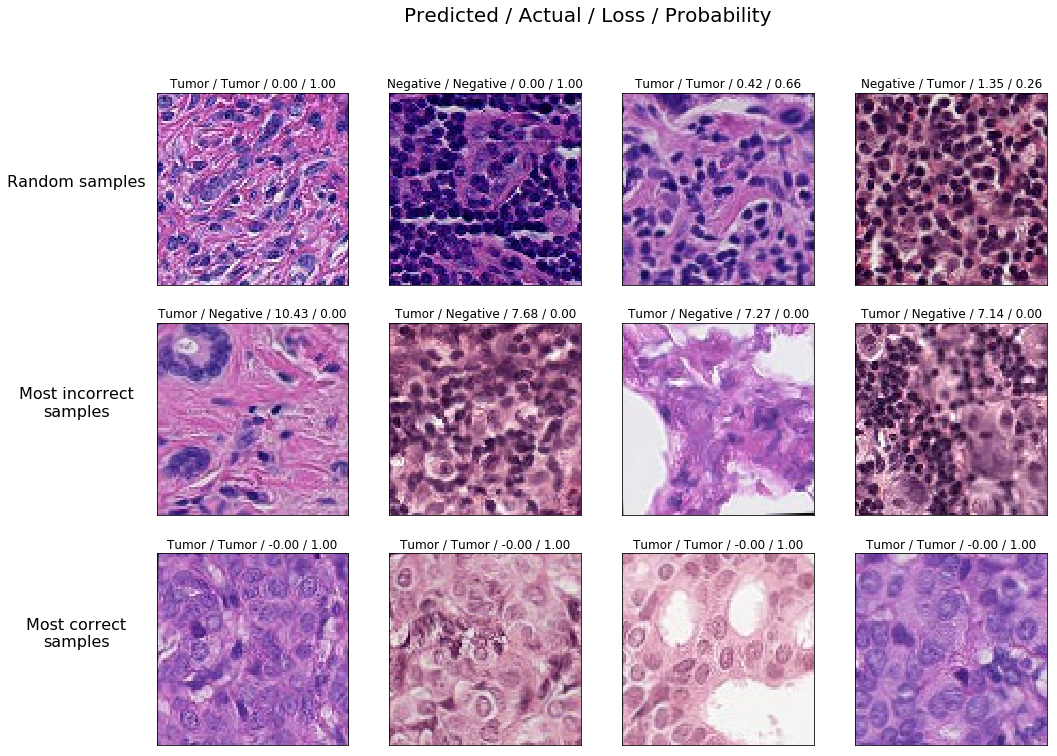

In [77]:
plot_overview(interp, ['Negative', 'Tumor'])

**Where is the model seeing what it sees?**

**Gradient-Weighted Class Activations Mapping (Grad-CAM)**

This is the method to produce a coarse localization map highlighting the areas that the model considers important for the classification decision. The visual explantion allows transparency to the model. It creates an ease to notice if it has learned wrong things. 

A great example of this is, looking at a dog breed classifier and all the the images of a certain dog breed would have been taken at a dog show competition. There is a good chance that the model would learn to recongize the competition surroundings instead of the dog's features with that breed. If this is the case we would need to collect new data with a more diverse data of the breed not being learned. 

In [78]:
from fastai.callbacks.hooks import * 

#hook into forward pass 
def hooked_backward(m, oneBatch, cat): 
    #hook into the convolutional part = m[0] (level) of the model 
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [85]:
#Creating a utility function for getting the validation image with the activation map
def getHeatmap(val_index): 
    """
    Returns the validation set image and the activation map
    """
    m = learner.model.eval() #gets the model 
    tensorImg, cl = data.valid_ds[val_index]
    #create a batch from the one image
    oneBatch,  _ = data.one_item(tensorImg)
    oneBatch_im = vision.Image(data.denorm(oneBatch)[0])
    #take im convert batch tensor to grayscale image with openCV
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

In [88]:
#Look at the plot above adding the two function above
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val, tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\n 1.Predicted / 2. Actual / 3. Loss / 4. Probability', fontsize=20)
    
    #Random
    for i in range(4): 
        random_index = randint(0, len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0), interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

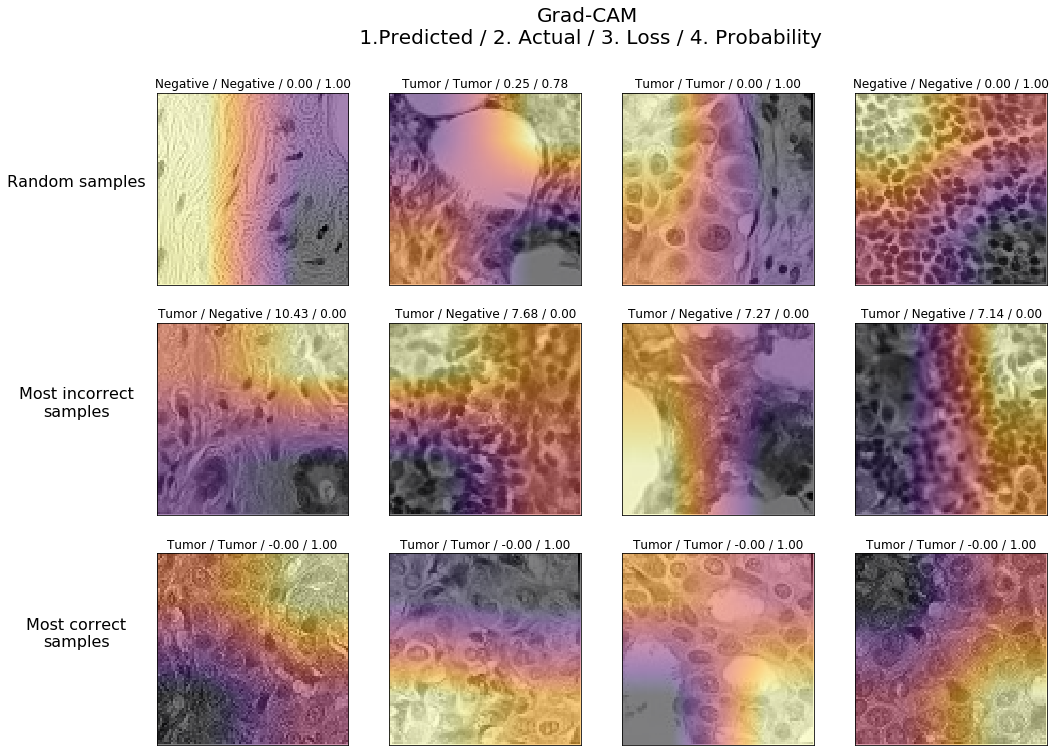

In [89]:
plot_heatmap_overview(interp, ['Negative', 'Tumor'])

This shows the activation maps of the predicted category so if the label is tumor, the visualization shows all the places where the model thinks the ``tumor`` patterns are.

### Other Metrics To Look At

In [90]:
#ROC Curve and AUC
from sklearn.metrics import roc_curve, auc
probs = np.exp(preds[:,1])
#Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

#Compute ROC area
roc_auc = auc(fpr,tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9927330903055009


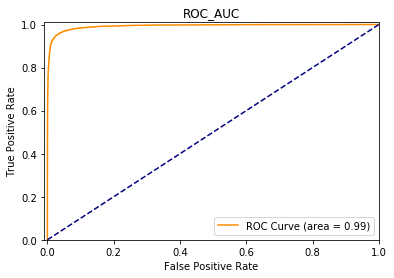

In [91]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_AUC')
plt.legend(loc='lower right')

### Predictions

**BUT FIRST TTA (Test Time Augmentation)**

To evaluate the model we run inference on all test images. The results will probably improve if predictions of multiple times per image and average out the results.

In [141]:
data.test_ds

data/test/fb540d97f4d200f2534a0a099bcb9c40014e1455.tif
data/test/5f53f9f84ee2c9e8a9f769129a54a188dd542e26.tif
data/test/20ccb7f5213a1921c78b184c84d5904253a2d540.tif
data/test/ac7f9cd9ddfbd13c6f28c58a0cc0c6f5b67e84c0.tif
data/test/aed8520cb29c5a493a05d51b3d55e3b3aa93409e.tif


LabelList
y: EmptyLabelList (57459 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: MyImageItemList (57459 items)
[Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90), Image (3, 90, 90)]...
Path: data/train

In [113]:
#Load Best Model 
learner.load(name);name

'densenet169-tuned-unfrozen-90'

In [ ]:
doc(DatasetType)

In [ ]:
def readCroppedImage(path, augmentations= True): 
    '''
    Augmentation paramters are included for counting statistics from images
    where one doesn't want to have augmentations.
    '''
    #read images with OpenCV
#     print(path)
    bgr_img = cv2.imread(path)
    #Flip to rgb for viz
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations): 
        return rgb_img /225 
    
    #random rotation 
    rotation = random.randint(-RANDOM_ROTATION, RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1): 
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48), rotation,1) # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    #crop to center and normalize to 0-1 range 
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    #normalize images
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    #random flip 
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor): 
        rgb_img = rgb_img[:,::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1,:]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    #clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img

In [114]:
len(learner.data.test_ds.items)

57458

In [115]:
# Using fastai this is how we would do it
# Fastai does additional augmentation that the image loader created already has some
# preds_test, y_test = learner.TTA(ds_type=DatasetType.Test)

#if you don't want to use TTA
# preds,y = learner.get_preds(ds_type=DatasetType.Test, with_loss=False)

# With out Fastai we will manually make iterations to cover the different combinations of augs 
#Predict then average
n_aug = 12
preds_n_avg = np.zeros((len(learner.data.test_ds.items),2))

for n in tqdm_notebook(range(n_aug), 'Running TTA...'):
    preds,y = learner.get_preds(ds_type=DatasetType.Test, with_loss=False)
    preds_n_avg = np.sum([preds_n_avg, preds.numpy()], axis=0)
preds_n_avg = preds_n_avg / n_aug

In [116]:
# Next, we will transform class probabilities to just tumor class probabilities
print('Negative and Tumor Probabilities: ' + str(preds_n_avg[0]))
tumor_preds = preds_n_avg[:, 1]
print('Tumor probability: ' + str(tumor_preds[0]))
# If we wanted to get the predicted class, argmax would get the index of the max
class_preds = np.argmax(preds_n_avg, axis=1)
classes = ['Negative','Tumor']
print('Class prediction: ' + classes[class_preds[0]])

Negative and Tumor Probabilities: [0.974818 0.025182]
Tumor probability: 0.025182212780540187
Class prediction: Negative


In [125]:
SAMPLE_SUB = 'data/sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB); sample_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [126]:
sample_list = list(sample_df.id)
#list tumor preds / order below will not match sample_df
pred_list = [p for p in tumor_preds]

In [129]:
learner.data.test_ds.items

array(['//./data/test/fb540d97f4d200f2534a0a099bcb9c40014e1455.tif',
       '//./data/test/5f53f9f84ee2c9e8a9f769129a54a188dd542e26.tif',
       '//./data/test/20ccb7f5213a1921c78b184c84d5904253a2d540.tif',
       '//./data/test/ac7f9cd9ddfbd13c6f28c58a0cc0c6f5b67e84c0.tif', ...,
       '//./data/test/58ba2df04686bf614fee324201331ecc98d46bcf.tif',
       '//./data/test/9c08e36badca1b23733c6283f4784aa20c3fa9e8.tif',
       '//./data/test/64ea159c6cb227da8404cdc9ed63bb6ca9aa0a4e.tif',
       '//./data/test/f54f13d591313ea7e484226257a4173e27f5852f.tif'], dtype='<U59')

In [130]:
#to know ids of the predictions we need to create a dict
pred_dic = dict((key, value) for (key,value) in zip(learner.data.test_ds.items, pred_list))

In [133]:
#Edit the key or map what we have in the data
pred_list_cor = [pred_dic['//./data/test/' + id + '.tif'] for id in sample_list]

In [135]:
df_sub = pd.DataFrame({'id':sample_list, 'label':pred_list_cor})

In [140]:
df_sub.to_csv('{0}_submission.csv'.format(MODEL_PATH), header=True, index=False)

In [141]:
df_sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.005559
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.086444
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.000054
3,2c35657e312966e9294eac6841726ff3a748febf,0.002823
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.008603


### Next 

- Delopy Model Example

- Build App

- Use different agumentation resize the data (32x32) images is all that we are looking at right now so we want to be make our pictures just about the interesting parts of the image